# Data Mining Report

**Authors:** Johannes HYGRELL, Andrieu GIRARD, Hugo DEGEORGES, Benjamin KERMANI \
**Prof:** Dr. Mehdi Kaytoue

## Table of Contents

- [1 - Introduction](#1)
- [2 - Packages & Global Variables](#2)
- [3 - Data Acquisition](#3)
- [4 - Data Pre-processing](#4)
- [5 - Data Visualisation](#5)
- [6 - Method 1 : Scaled Manhattan Distance](#6)
- [7 - Method 2 : Keyboard Image Mapping](#7)
- [8 - Method 3 : Decision Tree](#8)
- [9 - Evaluation](#9)
- [10 - Conclusion](#10)

<a name='1'></a>
## 1 - Introduction

Data mining project on keystroke dynamics as part of the Machine Learning specialization at INSA Lyon (5IF - OT2).

The goal is to study different research aspects of keystroke dynamics using data mining and knowledge discovery techniques.

- **Research questions we want to address**
    - To what extent can we identify users only using their keystrokes signature?
    - Has the keyboard layout an influence on the users keystroke profile?
    - What are the most important (i.e discriminant) features extractable from the data?
- **Data acquisition**
    - Keylogger to acquire our own data on a fixed text (pangrams) for the references, and [random texts](https://www.typelit.io/) for the traces to re-identify
- **Methods**
    - Scaled manhattan distance
    - Keyboard image mapping
    - Decision Tree
- **Data evaluation**
    - Accuracy
    - f1-Score
    - log-loss Crossentropy

Roles of the Authors:

- Johannes HYGRELL: Decision Tree Model, Scaled Manhattan Distance Model, Evaluation/Train-Test Code
- Andrieu GIRARD: Research, Data Visualization
- Hugo DEGEORGES: Key logging functionality, Preprocessing, Keyboard Image Mapping Model, Data Visualization
- Benjamin KERMANI: Preprocessing, Decision Tree Model

Bibliography:
- Keystroke Dynamics for User Authentication (https://projet.liris.cnrs.fr/imagine/pub/proceedings/CVPR2012/data/papers/workshops/W13_18.pdf)
- Utilizing overt and latent linguistic structure to improve keystroke-based authentication (https://www.sciencedirect.com/science/article/abs/pii/S0262885616301019)

<a name='2'></a>
## 2 - Packages & Global Variables

In [43]:
import pandas as pd 
import numpy as np
from datetime import datetime
import os
from os import listdir
from os.path import isfile, join
import math
import string
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.path as path_bis
import matplotlib.patches as patches
import plotly.graph_objects as go
import cv2 # pip install opencv-python
from pynput.keyboard import Key, Listener
import logging
from sklearn import tree
from sklearn.metrics import accuracy_score, f1_score, log_loss, roc_auc_score


# Global variables
filepaths = []
INPUT_DATA_FILEPATH = "data/training/input_data/"
filepaths.append(INPUT_DATA_FILEPATH)
INPUT_DATA_UNKNOWN_FILEPATH = "data/test/input_data_unknown/"
filepaths.append(INPUT_DATA_UNKNOWN_FILEPATH)

INPUT_DATA_MERGED_FILEPATH = "data/training/input_data_merged/"
filepaths.append(INPUT_DATA_MERGED_FILEPATH)

PREPROCESSED_DATA_FILEPATH = "data/training/preprocessed_data/"
filepaths.append(PREPROCESSED_DATA_FILEPATH)
PREPROCESSED_DATA_UNKNOWN_FILEPATH = "data/test/preprocessed_data_unknown/"
filepaths.append(PREPROCESSED_DATA_UNKNOWN_FILEPATH)

REFERENCE_FILEPATH = "data/training/reference/"
filepaths.append(REFERENCE_FILEPATH)
REFERENCE_UNKNOWN_FILEPATH = "data/test/reference_unknown/"
filepaths.append(REFERENCE_UNKNOWN_FILEPATH)

Run the following cell if you need to create directories or clear the directories containing the preprocessed data :

In [44]:
for filepath in filepaths:
    # Create directory if DNE
    if not os.path.exists(filepath):
        os.makedirs(filepath)

    # Delete files if not input directories
    if filepath not in [INPUT_DATA_FILEPATH, INPUT_DATA_UNKNOWN_FILEPATH]:
        for f in os.listdir(filepath):
            os.remove(os.path.join(filepath, f))   


<a name='3'></a>
## 3 - Data Acquisition

Before processing data, we first need to acquire it. `pynput` python library allow us to acquire keyboard inputs. \
The generated data will have the following format: `{timestamp | key | [press/release]}`

example : `2021-11-20 10:45:45,858|Key.enter|release`

The below python script will ask you to choose a filename, you then write what's prompted in the console (pangrams) using your keyboard. Once you are done, you have to stop the program. A new file should have been generated. We followed that procedure to get our training data.

To collect the re-identification traces, you have to change the path where you want to store the generated file, go to [typelit.io](https://www.typelit.io/) and launch the python script. Once you are done, stop the program. 

*Note: We collected the necessary data in `data/train/input_data` and `data/test/input_data_unknown` folders*, it's not necessary for you to acquire your input, but if you want to be part of our training and/or re-identification dataset, feel free to collect your inputs.

In [45]:
# filename convention is :
# <name>_<nb_trace> for reference using pangrams
# unknown_<name>_<nb_trace> for data to re-identify
saving_path = INPUT_DATA_FILEPATH
user_filename = input("Filename (ex. andrieu_1): ")
logging.basicConfig(filename=(saving_path + user_filename + ".csv"), level=logging.DEBUG, format="%(asctime)s|%(message)s")

text = "Portez ce vieux whisky au juge blond qui fume.\n"
text += "Joyeux, ivre, fatigué, le nez qui pique, Clown Hary skie dans l’ombre.\n"
text += "Monsieur Jack, vous dactylographiez bien mieux que Wolf.\n"
text += "Hier, au zoo, j'ai vu dix guépards, cinq zébus, un yak et le wapiti fumer.\n"
text += "Yves fugue en BMX chez Will, qui est près du Kilimandjaro.\n"
text += "J’aime l’idée que le plus grand des Sex-symbols new-yorkais n’était qu’un chien dans un foyer de Brazzaville.\n"

print("Veuillez écrire le text ci-dessous et arrêter le programme une fois fini:\n\n" + text)


def on_press(key):
    logging.info(str(key)+"|press")
def on_release(key):
    logging.info(str(key)+"|release")
 
with Listener(on_press=on_press, on_release=on_release) as listener :
    listener.join()

KeyboardInterrupt: Interrupted by user

<a name='4'></a>
## 4 - Data Pre-processing

In the event that a key is pressed for a 'long time' (at least 2 consecutive rows in the log file with the same 'Key' value and 'Action' = press), we only keep the first pressed action.
<br>We also create some columns for specific keys like Shift, Alt, Win, Ctrl

Now that we acquired raw data in

- `data/train/input_data/` (contains traces we will use as reference)
- `data/test/input_data_unknown` (contains traces we will use to re-identify)

we need to pre-process the data for use in our models. This includes the following steps: 

1. **Merging data :** We may have multiple traces (raw files) per user, we will concatenate these into one file per user.
2. **Pre-processing data :** Clean the data (delete duplicate tuples) and slightly modify the data structure (add binary column giving information regarding `shift` state)
3. **Creating references :** Aggregate statistics per key.

### 4.1 - Merging Input Data

Our naming convention for the data files is the following: `<name>_<nb_traces>.csv`

The 2 following methods are equivalent. We loop over the users, enumerating their number of traces. Then, we concatenate them into a single file.

*Note: We do not concatenate test traces (files in `data/test/input_data_unknown`) to have more re-identification traces for testing.*

In [46]:
columns = ['Timestamp', 'Key', 'Action']
last_elements = {}

def merge_input_data_with_dict(input_path, path_merged):
    user_to_count = {}
    files = [os.path.splitext(filename)[0] for filename in listdir(input_path)]
    for file_name in files:
        user_name = file_name.split('_')[0]
        if user_name in user_to_count:
            # already in map, add 1 to counter
            user_to_count[user_name] = user_to_count[user_name] + 1 
        else:
            # not in map, add and set counter to 1
            user_to_count[user_name] = 1
    for user_name in user_to_count.keys():
        counter = user_to_count[user_name]
        all_filenames = []
        Ts_last_elems = []
        for i in range(1, counter + 1):
            all_filenames = np.append(all_filenames, [input_path+user_name+'_'+str(i)+'.csv'])
            tmp = pd.read_csv(input_path+user_name+'_'+str(i)+'.csv', sep = '|', names = columns, encoding = "ISO-8859-1")
            last = tmp['Timestamp'].iloc[-1]
            last = datetime.strptime(last, '%Y-%m-%d %H:%M:%S,%f')
            Ts_last_elems.append(last)
        last_elements[user_name] = Ts_last_elems  
        df_merged = (pd.read_csv(f, sep='|', names=columns, encoding = "ISO-8859-1") for f in all_filenames)
        df_merged = pd.concat(df_merged, ignore_index=False)
        df_merged.to_csv(path_merged + user_name +'.csv', sep='|', encoding = "ISO-8859-1")    
    
def merge_input_data(input_path, path_merged):
    user_list = files = [os.path.splitext(filename)[0] for filename in listdir(input_path)]
    samples_number = np.empty((2,2))
    samples_number = np.delete(samples_number, [0,1], 0)
    user_name = user_list[0].split('_')[0]
    for h in range(len(user_list)): 
        if user_list[h].split('_')[0] != user_name or h == len(user_list) - 1:
            if h == len(user_list) - 1:
                samples_number = np.append(samples_number,[[user_name, int(position)]], axis = 0)
                if user_list[h].split('_')[0] != user_name:
                    samples_number = np.append(samples_number,[[user_list[h].split('_')[0], 1]], axis = 0)
                else:
                    string = samples_number[-1][1]
                    i = int(string) + 1
                    samples_number[-1][1] = str(i)
            else:
                samples_number = np.append(samples_number,[[user_name, int(position)]], axis = 0)
            user_name = user_list[h].split('_')[0]
        position = user_list[h].split('_')[1]
    for i in range(0, len(samples_number)):
        sample_number = samples_number[i][1]
        all_filenames = []
        Ts_last_elems = []
        for j in range(1, int(sample_number)+1):
            all_filenames = np.append(all_filenames, [input_path+samples_number[i][0]+'_'+str(j)+'.csv'])
            tmp = pd.read_csv(input_path+samples_number[i][0]+'_'+str(j)+'.csv', sep = '|', names = columns, encoding = "ISO-8859-1")
            last = tmp['Timestamp'].iloc[-1]
            last = datetime.strptime(last, '%Y-%m-%d %H:%M:%S,%f')
            Ts_last_elems.append(last)
        last_elements[user_name] = Ts_last_elems  
        df_merged = (pd.read_csv(f, sep='|', names=columns, encoding = "ISO-8859-1") for f in all_filenames)
        df_merged = pd.concat(df_merged, ignore_index=False)
        df_merged.to_csv(path_merged+samples_number[i][0]+'.csv', sep='|', encoding = "ISO-8859-1")

We will call this function to generate a single file per user for the files stored in `data/train/input_data`.

In [47]:
merge_input_data(INPUT_DATA_FILEPATH, INPUT_DATA_MERGED_FILEPATH)     

Here is the list of files we have generated in `data/train/input_data_merged`, as well as and `data/test/input_data_unknown_merged`.

In [48]:
files = [os.path.splitext(filename)[0] for filename in listdir(INPUT_DATA_MERGED_FILEPATH)]
files_unknown = [os.path.splitext(filename)[0] for filename in listdir(INPUT_DATA_UNKNOWN_FILEPATH)]
print("merged data files :",files)
print("initial test data files:", files_unknown)

merged data files : ['andrieu', 'benjamin', 'hugo', 'johannes', 'robin', 'sylvain', 'theotime']
initial test data files: ['andrieu_1', 'andrieu_2', 'andrieu_3', 'andrieu_4', 'andrieu_5', 'andrieu_6', 'andrieu_7', 'benjamin_1', 'benjamin_2', 'benjamin_3', 'benjamin_4', 'benjamin_5', 'johannes_1', 'theotime_1']


### 4.2 - Pre-processing Input Data

We now have one file per user. We then clean it and collect information (e.g, was shift pressed?).

The goal is to restructure `{timestamp | key | [press/release]}` into `{timestamp | key | [press/release] | shift_bool}`.

The following methods do three things:
1. Clean the data : `preprocess_holding(...)` deletes duplicate lines. This occurs when a key was pressed for too long.
2. Shift key usage : we want to collect the information regarding the usage of the shift key because it could affect the typing characteristics of the user. `is_shifted_key(...)` determines the shift state.
3. Append to dataframe : `preprocess_shift(...)` appends a column with shift key information to the dataframe.

In [49]:
columns_bis = ['Timestamp', 'Key', 'Action', 'Shift']

def is_shifted_key(df, key_index):
    press = False
    release = False
    for i in range(key_index, df.index.start-1, -1):
        if df['Key'][i] == 'Key.shift' and df['Action'][i] == 'press':
            press = True
            for j in range(key_index, i, -1):
                if df['Key'][j] == 'Key.shift' and df['Action'][j] == 'release':
                    release = True
                    break
            break
    if press == True and release == False:
        return True
    else:
        return False

def preprocess_holding(dataframe):
    for i in range(dataframe.index.start, dataframe.index.stop):
        if i < dataframe.index.stop:
            current_key = dataframe['Key'][i]
            if dataframe['Action'][i] == 'press':
                press = True
                j = i + 1
                while press:
                    if j < dataframe.index.stop and dataframe['Action'][j] == 'press' and current_key == dataframe['Key'][j]:
                        dataframe = dataframe.drop([j])
                        dataframe = dataframe.reset_index(drop=True)
                    else:
                        break
    return dataframe
    
def preprocess_shift(dataframe):
    dataframe_bis = pd.DataFrame(columns=columns_bis)
    for i in range(dataframe.index.start, dataframe.index.stop):
        if is_shifted_key(dataframe, i):
            tmp = pd.DataFrame([[dataframe['Timestamp'][i], dataframe['Key'][i], dataframe['Action'][i], 1]], columns = columns_bis)
            dataframe_bis = dataframe_bis.append(tmp)
        else:
            tmp = pd.DataFrame([[dataframe['Timestamp'][i], dataframe['Key'][i], dataframe['Action'][i], 0]], columns = columns_bis)
            dataframe_bis = dataframe_bis.append(tmp)
    dataframe_bis = dataframe_bis.reset_index(drop=True)
    dataframe = dataframe_bis
    return dataframe


We use the defined functions  to generate one **pre-processed** file per user for both train and test sets. The execution of the cell may take a few minutes.

In [50]:
training_user_list = os.listdir(INPUT_DATA_MERGED_FILEPATH)
print("CREATING PRE-PROCESSED FILES FOR TRAINING DATA")
for user in range(len(training_user_list)):
    dataframe = pd.read_csv(INPUT_DATA_MERGED_FILEPATH+training_user_list[user], sep="|", names=columns, encoding = "ISO-8859-1")
    dataframe = dataframe.reset_index(drop=True)
    dataframe = dataframe.drop([0])
    dataframe = dataframe.reset_index(drop=True)
    dataframe = preprocess_holding(dataframe)
    dataframe = preprocess_shift(dataframe)
    dataframe['Timestamp'] = pd.to_datetime(dataframe['Timestamp'], format='%Y-%m-%d %H:%M:%S,%f')  
    dataframe.to_csv(PREPROCESSED_DATA_FILEPATH+training_user_list[user], sep='|', encoding = "ISO-8859-1")     
    print("Successfully created preprocessed file: ", training_user_list[user])

unknown_user_list = os.listdir(INPUT_DATA_UNKNOWN_FILEPATH)
print("CREATING PRE-PROCESSED FILES FOR TESTING DATA")
for user in range(len(unknown_user_list)):
    dataframe = pd.read_csv(INPUT_DATA_UNKNOWN_FILEPATH+unknown_user_list[user], sep="|", names=columns, encoding = "ISO-8859-1")
    dataframe = dataframe.reset_index(drop=True)
    dataframe = dataframe.drop([0])
    dataframe = dataframe.reset_index(drop=True)
    dataframe = preprocess_holding(dataframe)
    dataframe = preprocess_shift(dataframe)
    dataframe['Timestamp'] = pd.to_datetime(dataframe['Timestamp'], format='%Y-%m-%d %H:%M:%S,%f')  
    dataframe.to_csv(PREPROCESSED_DATA_UNKNOWN_FILEPATH+unknown_user_list[user], sep='|', encoding = "ISO-8859-1")     
    print("Successfully created preprocessed file: ", unknown_user_list[user])
    
print("SUCCESSFULLY CREATED ALL PRE-PROCESSING FILES")

CREATING PRE-PROCESSED FILES FOR TRAINING DATA
Successfully created preprocessed file:  andrieu.csv
Successfully created preprocessed file:  benjamin.csv
Successfully created preprocessed file:  hugo.csv
Successfully created preprocessed file:  johannes.csv
Successfully created preprocessed file:  robin.csv
Successfully created preprocessed file:  sylvain.csv
Successfully created preprocessed file:  theotime.csv
CREATING PRE-PROCESSED FILES FOR TESTING DATA
Successfully created preprocessed file:  andrieu_1.csv
Successfully created preprocessed file:  andrieu_2.csv
Successfully created preprocessed file:  andrieu_3.csv
Successfully created preprocessed file:  andrieu_4.csv
Successfully created preprocessed file:  andrieu_5.csv
Successfully created preprocessed file:  andrieu_6.csv
Successfully created preprocessed file:  andrieu_7.csv
Successfully created preprocessed file:  benjamin_1.csv
Successfully created preprocessed file:  benjamin_2.csv
Successfully created preprocessed file:  

To make sure that we have successfully created all the pre-processed files we needed, we can double-check and show the list of files we have in the concerned directories:

In [51]:
files = [os.path.splitext(filename)[0] for filename in listdir(PREPROCESSED_DATA_FILEPATH)]
files_unknown = [os.path.splitext(filename)[0] for filename in listdir(PREPROCESSED_DATA_UNKNOWN_FILEPATH)]
print("pre-processed training files", PREPROCESSED_DATA_FILEPATH, ":",files)
print("pre-processed test files :", files_unknown)

pre-processed training files data/training/preprocessed_data/ : ['andrieu', 'benjamin', 'hugo', 'johannes', 'robin', 'sylvain', 'theotime']
pre-processed test files : ['andrieu_1', 'andrieu_2', 'andrieu_3', 'andrieu_4', 'andrieu_5', 'andrieu_6', 'andrieu_7', 'benjamin_1', 'benjamin_2', 'benjamin_3', 'benjamin_4', 'benjamin_5', 'johannes_1', 'theotime_1']


### 4.3 - Creating references

Finally, we need to pass from the preprocessed data structure we established in `4-2` to a statistical data structure.
We decided to aggregate the data according to the following format :

`{Key|Shift|HD_mean|HD_std|DL_mean|DL_std}`

>*Hold Duration (HD) : Duration between press and release of the same key* <br>
*Digraph latency (DL) : Flight time between two keystrokes*

The reference file for one user will contain all the keys he pressed. They will be represented by a single tuple in this file.

First, we need to define a function to find the mapping from lower to uppercase characters. This mapping is done according to an  AZERTY layout.

In [52]:
lower_alphabet = list(string.ascii_lowercase)
upper_alphabet = list(string.ascii_uppercase)

# key : lowercase character
# value : uppercase character
mapping = {}
for i in range(len(lower_alphabet)):
    mapping[lower_alphabet[i]] = upper_alphabet[i]

mapping[','] = '?'
mapping[';'] = '.'
mapping[':'] = '/'
mapping['!'] = '§'
mapping['^'] = '¨'
mapping['&'] = '1'
mapping['é'] = '2'
mapping['"'] = '3'
mapping['\''] = '4'
mapping['('] = '5'
mapping['-'] = '6'
mapping['è'] = '7'
mapping['_'] = '8'
mapping['ç'] = '9'
mapping['à'] = '0'
mapping[')'] = '°'
mapping['='] = '+'
mapping['ù'] = '%'
mapping['$'] = '£'

# return the key attached to the value given as parameter
def get_key(val):
  for key, value in mapping.items():
         if val == value:
             return key


Then, we need to define a few methods to compute the statistics we are looking for: mean and standard deviation for hold duration and dwell time metrics.

We split the process of computing the metrics and the generation of the reference file into two functions:
- `metrics_computation()` : Compute dwell time and hold duration using helper functions
- `compute_reference()` : Compute mean and standard deviation for these metrics

We defined a few helper functions:
- `search for press()` : find the index of a key that is in the `pressed` state in a given dataframe
- `search for release()` : find the index of a key that is in the `released` state given a press index
- `search_for_following_key()` : find the dataframe index of the next key
- `contains()` : Checks if a given key is in a dataframe or not

In [53]:
columns_nd = ['Key1', 'Key2', 'HD', 'HTD', 'CDT', 'DL', 'Shift']
columns_ref = ["Key", "Shift", "HD_mean", "HD_std", "DL_mean", "DL_std"]

df = pd.DataFrame(columns = columns_nd)
df_bis = pd.DataFrame(columns = columns_nd)

def search_for_press(df):
    for i in range(df.index.start, df.index.stop):
        if df['Action'][i] == 'press':
            return i

def search_for_release(df, press_index):
    lower = df['Key'][press_index]
    upper = df['Key'][press_index]
    if df['Key'][press_index] != "'" and df['Key'][press_index].startswith('Key.') == False:
        val = df['Key'][press_index][1:-1]
        if val in mapping.keys():
            upper = mapping[val]
        if val in mapping.values():
            lower = get_key(val)
    upper = "'"+upper+"'"
    lower = "'"+lower+"'"
    for i in range (press_index, df.index.stop):
        if (df['Key'][i] == df['Key'][press_index] or df['Key'][i].lower() == df['Key'][press_index].lower() or df['Key'][i] == lower or df['Key'][i] == upper) and df['Action'][i] == 'release':
            return i
        
def search_for_following_key(df, key_index):
    for i in range(key_index, df.index.stop):
        if df['Key'][i] != df['Key'][key_index] and df['Action'][i] == 'press':
            return i
        
def contains(dataframe, elem):
    for i in dataframe.index:
        if elem == dataframe['Key'][i]:
            return True

In [54]:
def metrics_computation(dataframe):
    df = pd.DataFrame(columns = columns_nd)                  
    while dataframe.empty == False:
        end = False
        if dataframe['Action'][0] == 'release':
            dataframe = dataframe.drop([0])
            dataframe = dataframe.reset_index(drop=True)

        press_index = search_for_press(dataframe)
        release_index = search_for_release(dataframe, press_index)
        
        if dataframe.index.stop-dataframe.index.start <= 2:
            end = True
        if end == False:
            following_key_press_index = search_for_following_key(dataframe, press_index)
            following_key_release_index = search_for_release(dataframe, following_key_press_index)
            if following_key_release_index == None:
                dataframe = dataframe.drop([following_key_press_index])
                dataframe = dataframe.reset_index(drop=True)
                continue
            Key1 = dataframe['Key'][press_index]
            Key2 = dataframe['Key'][following_key_press_index]

            HD = dataframe['Timestamp'][release_index] - dataframe['Timestamp'][press_index]
            HD = HD.total_seconds()
            HTD = dataframe['Timestamp'][following_key_release_index] - dataframe['Timestamp'][following_key_press_index]
            HTD = HTD.total_seconds()
            CDT = HD + HTD
            DL = dataframe['Timestamp'][following_key_press_index] - dataframe['Timestamp'][release_index]
            DL = DL.total_seconds()
            shift = dataframe['Shift'][press_index]
            """for y in range(len(last_elements[user])):
                if last_elements[user][y] == dataframe['Timestamp'][press_index] or last_elements[user][y] == dataframe['Timestamp'][release_index]:                    
                    tmp = pd.DataFrame([[Key1, Key2, HD, HTD, CDT, None, shift]], columns = columns_nd)
                    break
                else:
                    tmp = pd.DataFrame([[Key1, Key2, HD, HTD, CDT, DL, shift]], columns = columns_nd)"""
            tmp = pd.DataFrame([[Key1, Key2, HD, HTD, CDT, DL, shift]], columns = columns_nd)
            dataframe = dataframe.drop([press_index, release_index])
            dataframe = dataframe.reset_index(drop=True)
            
            df = df.append(tmp)
        else:
            Key1 = dataframe['Key'][press_index]
            HD = dataframe['Timestamp'][release_index] - dataframe['Timestamp'][press_index]
            HD = HD.total_seconds()
            HTD = None
            CDT = None
            DL = None
            shift = dataframe['Shift'][press_index]
            dataframe = dataframe.drop([press_index, release_index])
            tmp = pd.DataFrame([[Key1, None, HD, HTD, CDT, DL, shift]], columns = columns_nd)
            df = df.append(tmp)
    df = df.reset_index(drop=True)
    return df



def compute_reference(dataframe):
    df_ref = pd.DataFrame(columns = columns_ref)
    for i in dataframe.index:
        var = dataframe['Key1'][i]
        if contains(df_ref, var):
            continue
        hold_durations = []
        flight_durations = []
        hold_durations = np.append(hold_durations, dataframe['HD'][i])
        if dataframe['DL'][i] != None:
                        flight_durations = np.append(flight_durations, dataframe['DL'][i])
        for j in range(i+1, dataframe.index.stop):
            if dataframe['Key1'][i] == dataframe['Key1'][j] and dataframe['Shift'][j] == dataframe['Shift'][i]:
                    hold_durations = np.append(hold_durations, dataframe['HD'][j])
                    if dataframe['DL'][j] != None:
                        flight_durations = np.append(flight_durations, dataframe['DL'][j])
        mean_HD = np.mean(hold_durations)
        std_HD = np.std(hold_durations)
        mean_DL = np.mean(flight_durations)
        std_DL = np.std(flight_durations)
        result = pd.DataFrame([[dataframe['Key1'][i], dataframe['Shift'][i], mean_HD, std_HD, mean_DL, std_DL]], columns = columns_ref)
        df_ref = df_ref.append(result)    
        df_ref = df_ref.reset_index(drop=True)
                
    
    return df_ref 

We'll use functions we've defined in the previous cells, to generate one **reference** file per user, for both training and test dataset. This might take a while.

In [55]:
training_user_list = os.listdir(PREPROCESSED_DATA_FILEPATH)
print("CREATING REFERENCE FILES FOR TRAINING DATA")
for user in range(len(training_user_list)):
    dataframe = pd.read_csv(PREPROCESSED_DATA_FILEPATH+training_user_list[user], sep="|", names=columns_bis, encoding = "ISO-8859-1")
    dataframe = dataframe.reset_index(drop=True)
    dataframe = dataframe.drop([0])
    dataframe = dataframe.reset_index(drop=True)
    dataframe['Timestamp'] = pd.to_datetime(dataframe['Timestamp'], format='%Y-%m-%d %H:%M:%S.%f')   
    df_bis = metrics_computation(dataframe)
    df_ref = compute_reference(df_bis)
    df_ref = df_ref.reset_index(drop=True)
    df_ref.to_csv(REFERENCE_FILEPATH+training_user_list[user], sep='|', encoding = "ISO-8859-1")     
    print("Successfully created reference file: ", training_user_list[user])
    
unknown_user_list = os.listdir(PREPROCESSED_DATA_UNKNOWN_FILEPATH)
print("CREATING REFERENCE FILES FOR TESTING DATA")
for user in range(len(unknown_user_list)):
    dataframe = pd.read_csv(PREPROCESSED_DATA_UNKNOWN_FILEPATH+unknown_user_list[user], sep="|", names=columns_bis, encoding = "ISO-8859-1")
    dataframe = dataframe.reset_index(drop=True)
    dataframe = dataframe.drop([0])
    dataframe = dataframe.reset_index(drop=True)
    dataframe['Timestamp'] = pd.to_datetime(dataframe['Timestamp'], format='%Y-%m-%d %H:%M:%S.%f')   
    df_bis = metrics_computation(dataframe)
    df_ref = compute_reference(df_bis)
    df_ref = df_ref.reset_index(drop=True)
    df_ref.to_csv(REFERENCE_UNKNOWN_FILEPATH+unknown_user_list[user], sep='|', encoding = "ISO-8859-1")     
    print("Successfully created reference file: ", unknown_user_list[user])
    
print("SUCCESSFULLY CREATED ALL REFERENCE FILES")

CREATING REFERENCE FILES FOR TRAINING DATA
Successfully created reference file:  andrieu.csv
Successfully created reference file:  benjamin.csv
Successfully created reference file:  hugo.csv
Successfully created reference file:  johannes.csv
Successfully created reference file:  robin.csv
Successfully created reference file:  sylvain.csv
Successfully created reference file:  theotime.csv
CREATING REFERENCE FILES FOR TESTING DATA
Successfully created reference file:  andrieu_1.csv
Successfully created reference file:  andrieu_2.csv
Successfully created reference file:  andrieu_3.csv
Successfully created reference file:  andrieu_4.csv
Successfully created reference file:  andrieu_5.csv
Successfully created reference file:  andrieu_6.csv
Successfully created reference file:  andrieu_7.csv
Successfully created reference file:  benjamin_1.csv
Successfully created reference file:  benjamin_2.csv
Successfully created reference file:  benjamin_3.csv
Successfully created reference file:  benjam

Similarly, to make sure that we have successfully created all the required reference files we needed, we can double-check and show the list of files we have in the concerned directories:

In [56]:
files = [os.path.splitext(filename)[0] for filename in listdir(REFERENCE_FILEPATH)]
files_unknown = [os.path.splitext(filename)[0] for filename in listdir(REFERENCE_UNKNOWN_FILEPATH)]
print("reference training files :",files)
print("reference test files :", files_unknown)

reference training files : ['andrieu', 'benjamin', 'hugo', 'johannes', 'robin', 'sylvain', 'theotime']
reference test files : ['andrieu_1', 'andrieu_2', 'andrieu_3', 'andrieu_4', 'andrieu_5', 'andrieu_6', 'andrieu_7', 'benjamin_1', 'benjamin_2', 'benjamin_3', 'benjamin_4', 'benjamin_5', 'johannes_1', 'theotime_1']


<a name='5'></a>
## 5 - Data Visualisation

#### We decided to visualize the hold duration and compare them for different users.

`listAlphabet()` and `getPosa()` are two utils functions that returns lowercase 'a' to 'z' char array, and respectively returns the position index of the 'a' key in a dataframe.

In the following cell we can also find two similar functions that draw charts:
- `visualize()` : takes one parameter which is the name of the user you want to visualize hold duration of the characters returned by `listAlphabet()`

- `hold-comparison()` : takes one parameter which is an array containing the names of the users you want to visualize and compare hold duration

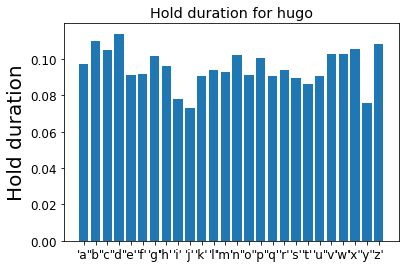

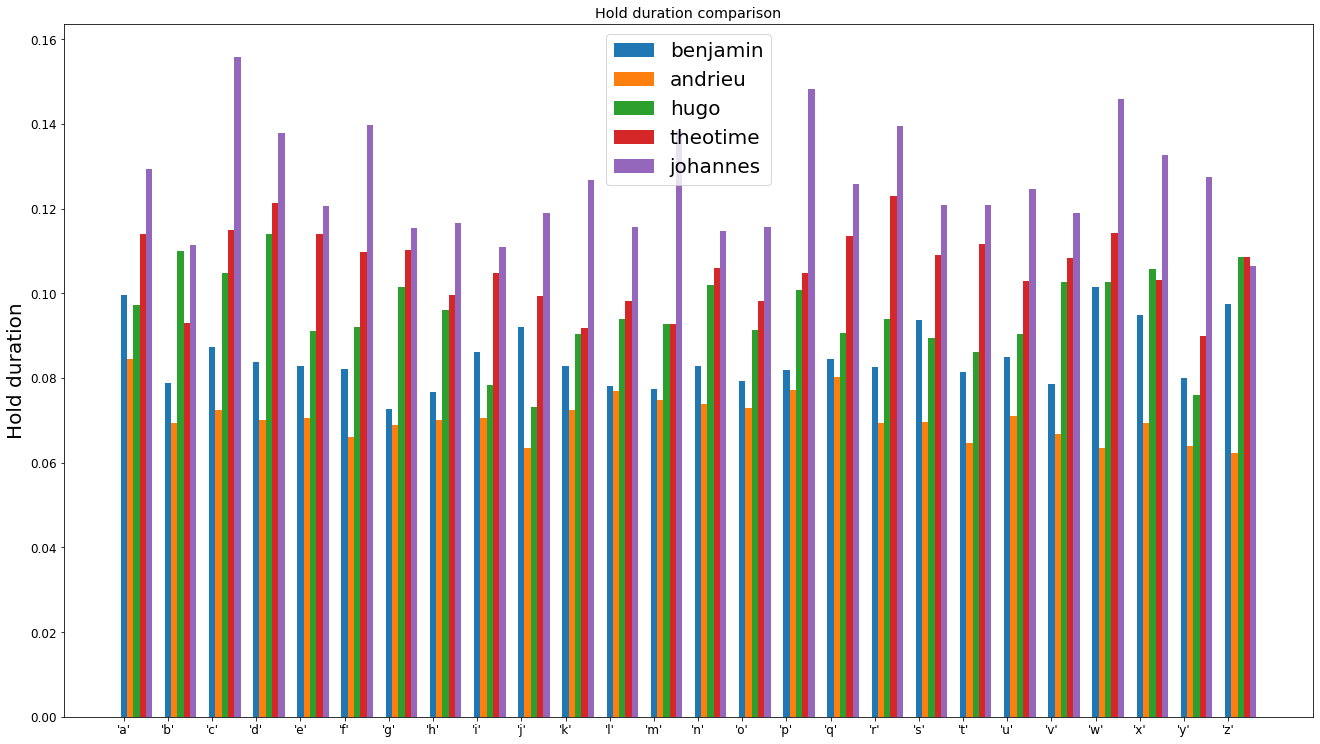

In [158]:
def listAlphabet():
  return list(string.ascii_lowercase)


def getPosa(dataframe):
  for i in dataframe.index:
    if dataframe.loc[i, 'Key'] == "\'a\'":
      return i
    
    

def visualize_hd(user):
    user_ref = pd.read_csv(REFERENCE_FILEPATH+user+".csv", sep="|", names=columns_ref, encoding = "ISO-8859-1")
    user_ref = user_ref.reset_index(drop=True)
    user_ref = user_ref.drop([0])
    user_ref = user_ref.reset_index(drop=True)
    user_ref = user_ref.sort_values("Key")

    
    user_ref = user_ref.reset_index(drop=True)
    user_ref["HD_mean"] = pd.to_numeric(user_ref["HD_mean"], downcast="float")
    
    a = getPosa(user_ref)
    
    labels = user_ref.iloc[a:a+26, 0]
    values = user_ref.iloc[a:a+26, 2]
    fig, ax = plt.subplots()
    rect = ax.bar(labels, values)
    
    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('Hold duration')
    ax.set_title('Hold duration for '+ user)

def hold_comparison(usernames):
    user_refs = []
    users_values = []
    rects = []
    
    for username in usernames:
        user_ref = pd.read_csv(REFERENCE_FILEPATH+username+".csv", sep="|", names=columns_ref, encoding = "ISO-8859-1")
        user_ref = user_ref.reset_index(drop=True)
        user_ref = user_ref.drop([0])
        user_ref = user_ref.reset_index(drop=True)
        user_ref = user_ref.sort_values("Key")
    
    
        user_ref = user_ref.reset_index(drop=True)
        user_ref["HD_mean"] = pd.to_numeric(user_ref["HD_mean"], downcast="float")
        user_refs.append(user_ref)
        users_values.append(user_ref.iloc[getPosa(user_ref):getPosa(user_ref)+26, 2])

    fig, ax = plt.subplots()
    labels = user_refs[0].iloc[getPosa(user_refs[0]):getPosa(user_refs[0])+26, 0]
    width = 1/(len(usernames)+2)  # the width of the bars
    x = np.arange(len(labels)) - len(username)
    for i, values in enumerate(users_values):
        rects.append(ax.bar(x + i*width, users_values[i], width, label=usernames[i]))
    
    fig.set_size_inches(18.5, 10.5)

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('Hold duration')
    ax.set_title('Hold duration comparison')
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend()

    

    fig.tight_layout()
    plt.show()
    

visualize_hd('hugo')
hold_comparison(['benjamin', 'andrieu', 'hugo', 'theotime', 'johannes'])

We can notice that users can be globaly more or less insistant on keys. Keyboard layout may have an influence on it. For example, if you type on a foreign layed out keyboard, you might hold the key longer.

We can visualize the exact same way the latency between two key strokes but it's a lot less meaningful 

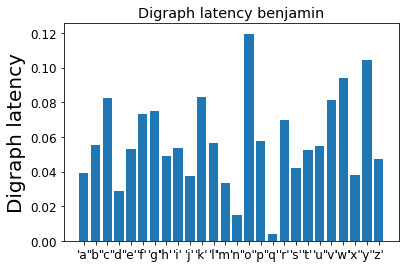

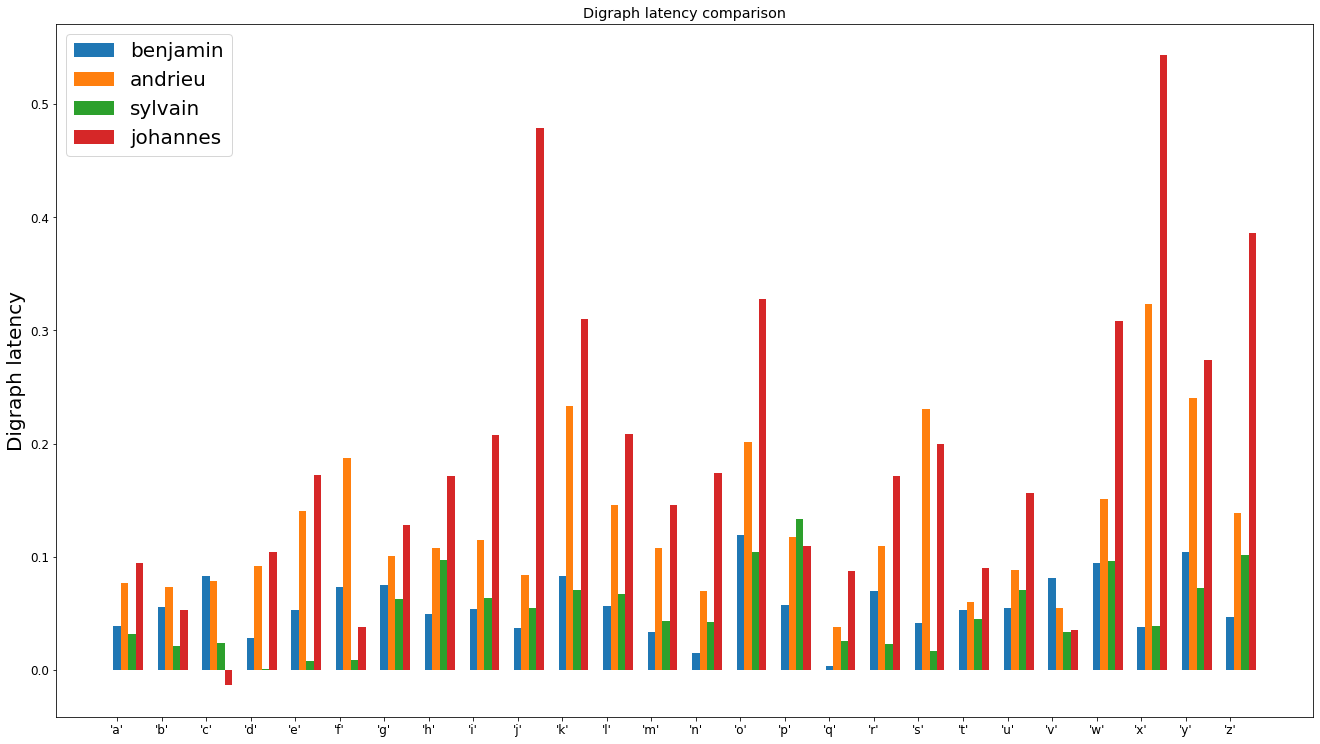

In [164]:
def visualize_dl(user):
    user_ref = pd.read_csv(REFERENCE_FILEPATH+user+".csv", sep="|", names=columns_ref, encoding = "ISO-8859-1")
    user_ref = user_ref.reset_index(drop=True)
    user_ref = user_ref.drop([0])
    user_ref = user_ref.reset_index(drop=True)
    user_ref = user_ref.sort_values("Key")

    
    user_ref = user_ref.reset_index(drop=True)
    user_ref["DL_mean"] = pd.to_numeric(user_ref["DL_mean"], downcast="float")
    
    a = getPosa(user_ref)
    
    labels = user_ref.iloc[a:a+26, 0]
    values = user_ref.iloc[a:a+26, 4]
    fig, ax = plt.subplots()
    rect = ax.bar(labels, values)
    
    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('Digraph latency')
    ax.set_title('Digraph latency '+ user)

def dl_comparison(usernames):
    user_refs = []
    users_values = []
    rects = []
    
    for username in usernames:
        user_ref = pd.read_csv(REFERENCE_FILEPATH+username+".csv", sep="|", names=columns_ref, encoding = "ISO-8859-1")
        user_ref = user_ref.reset_index(drop=True)
        user_ref = user_ref.drop([0])
        user_ref = user_ref.reset_index(drop=True)
        user_ref = user_ref.sort_values("Key")
    
    
        user_ref = user_ref.reset_index(drop=True)
        user_ref["DL_mean"] = pd.to_numeric(user_ref["DL_mean"], downcast="float")
        user_refs.append(user_ref)
        users_values.append(user_ref.iloc[getPosa(user_ref):getPosa(user_ref)+26, 4])

    fig, ax = plt.subplots()
    labels = user_refs[0].iloc[getPosa(user_refs[0]):getPosa(user_refs[0])+26, 0]
    width = 1/(len(usernames)+2)  # the width of the bars
    x = np.arange(len(labels)) - len(username)
    for i, values in enumerate(users_values):
        rects.append(ax.bar(x + i*width, users_values[i], width, label=usernames[i]))
    
    fig.set_size_inches(18.5, 10.5)

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('Digraph latency')
    ax.set_title('Digraph latency comparison')
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend()

    

    fig.tight_layout()
    plt.show()
    

visualize_dl('benjamin')
dl_comparison(['benjamin', 'andrieu', 'sylvain', 'johannes'])

Another way to visualize and compare the hold duration is to draw a polygon. It is clearer than the bar plot when we want to compare many users.

`performance_polygon()` draws the polygon according to criterias (here its the 'a' to 'z' char array) for different users.

The polygon might not get printed on github. You can find the a screenshot in the 'data_visualisation_images' folder.

In [165]:

def performance_polygon(Username, criterias):
        colors = ["blue", "red", "green", "orange", "brown", "deeppink","sienna",
                "gold", "olivedrab", "mediumspringgreen", "navy", "plum", "cadetblue", "darkmagenta"
                , "black"]
        fig = go.Figure()
        for i in range (0,len(Username)):
            user = pd.read_csv(REFERENCE_FILEPATH+Username[i]+".csv",  sep="|", names=columns_ref, encoding = "ISO-8859-1")
            user = user.reset_index(drop=True)
            user = user.drop([0])
            user = user.reset_index(drop=True)
            user["HD_mean"] = pd.to_numeric(user["HD_mean"], downcast="float")

            user = user.sort_values("Key")
            a = getPosa(user)
            values1 = user.iloc[a:a+26, 2]
            
            fig.add_trace(go.Scatterpolar(
                r=values1,
                theta=criterias,
                name=Username[i]
            ))
        name = ""
        for i in Username:
            name += i + " vs "
        size = len(name)
        name = name[:size - 3]
        fig.update_layout(
            title="Hold Duration : "+ name,
            xaxis_title="x Axis Title",
            yaxis_title="y Axis Title",
            font=dict(
                family="Courier New, monospace",
                size=18,
                color="#7f7f7f"
            )
        )   
        fig.update_layout(title_text="Hold Duration : "+ name, title_x=0.5) 
        fig.show()

            
        

criterias = listAlphabet()
print(criterias)
performance_polygon(["hugo", "benjamin", "johannes", "theotime"], criterias)

['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


These charts prove that the hold duration is a good metric for key-stroke recognition.

Even if the digraph latency does not show trends for users, it is a softer grain metric that allows to differentiate users with equivalent hold duration by analising keystroke rhythms.

<a name='6'></a>
## 6 - Method 1 : Scaled Manhattan Distance

We create a function that scales the train and test data needed for prediction. All model logic is implemented as functions so that we can call them later during evaluation.

In [61]:
from sklearn.preprocessing import StandardScaler

def scale(df_reference, to_identify):
    features = ["key_numerical", "Shift", "HD_mean", "HD_std", "DL_mean", "DL_std"]
    target = "label"

    scaler = StandardScaler()
    scaled_data_reference_X = scaler.fit_transform(df_reference[features])
    scaled_df_reference_X = pd.DataFrame(scaled_data_reference_X)
    scaled_df_reference_X.columns = features
    scaled_df_reference = pd.concat([scaled_df_reference_X.reset_index(drop=True), df_reference[target].reset_index(drop=True)], axis=1)

    scaled_to_identify = []
    for unknown in to_identify:
        scaled_data_unknown = scaler.transform(unknown)
        scaled_df_unknown = pd.DataFrame(scaled_data_unknown)
        scaled_df_unknown.columns = features
        scaled_to_identify.append(scaled_df_unknown)

    return scaled_df_reference, scaled_to_identify

We create a prediction method using the scaled manhattan distance.

In [62]:
def pred_SMD(df_reference, to_identify, verbose=False):
    predictions = []

    counter = 0
    for unknown in to_identify:
        distance_to_users = np.array([[0,0]])
        distance_to_users = np.delete(distance_to_users, 0, 0)
        index = 0

        references = [x for _, x in df_reference.groupby('label')]
        for reference in references:
            distance = 0
            reference = reference.reset_index(drop=True)
            
            for i in range(unknown.shape[0]):
                for j in range(reference.shape[0]):
                    if reference['key_numerical'][j] == unknown['key_numerical'][i]:
                        if float(reference['HD_std'][j]) != 0 and math.isnan(float(reference['HD_std'][j])) == False:
                            distance += abs(float(unknown['HD_mean'][i]) - float(reference['HD_mean'][j]))/float(reference['HD_std'][j])
                        if float(reference['DL_std'][j]) != 0 and math.isnan(float(reference['DL_std'][j])) == False:
                            distance += abs(float(unknown['DL_mean'][i]) - float(reference['DL_mean'][j]))/float(reference['DL_std'][j])

            distance_to_users = np.append(distance_to_users, [[index, distance]], axis = 0)
            index += 1

        minim = float('inf')
        res = 0
        for i in range(len(distance_to_users)):
            if distance_to_users[i][1] < minim:
                minim = distance_to_users[i][1]
                res = i
        
        pred = references[res]['label'].map(label_to_name_map).iloc[0]
        if verbose:
            counter += 1
            print(counter, "/", len(to_identify), "SMD-", "Predicting Class: ", pred)
        predictions.append(pred)
    
    return predictions

<a name='7'></a>
## 7 - Method 2 : Keyboard Image Mapping

<a name='8'></a>
## 8 - Method 3 : Decision Tree

We need to create the decision tree and fit it to our dataframe containing all our references.
We implement it as a function so that it can be called later during evaluation.

In [63]:
def fit_tree(df_reference):
    # tree training
    features = ["key_numerical", "Shift", "HD_mean", "HD_std", "DL_mean", "DL_std"]
    target = "label"

    Y_reference = df_reference[target]
    X_reference = df_reference[features]

    ## tree creation and fitting on the reference data
    clf = tree.DecisionTreeClassifier()
    clf = clf.fit(X_reference, Y_reference)
    return clf

Then, we need use the tree to get the predictions of the files we want to re-identify.

- For each file that we need to identify, the tree outputs a user prediction for each keyboard key, i.e `'A','a','c',...`. Thus, it predicts and maps one user for one key
- We need to compute the mean probability for each user, find the maximum mean probability, and get the user 
- We obtain a list of predictions for all unknown users

In [64]:
def pred_tree(to_identify, clf, verbose=False):
    # Run prediction for all unknowns and compare to truths to get accuracy
    predictions = []
    probabilities = []
    i = 0
    for unknown in to_identify:
        # tree returns predictions and probabilities for each key entry
        # average to get final prediction   
        probs = clf.predict_proba(unknown)
        prob_df = pd.DataFrame(probs)
        prob_df = prob_df.rename(columns=label_to_name_map)
        # calculate probability win sums for different labels
        pred_df = pd.DataFrame(columns=['prob_sum'])
        pred_df['prob_sum'] = prob_df.sum()
        # calculate mean probability per label
        pred_df['prob_mean'] = pred_df['prob_sum'] / pred_df['prob_sum'].sum()
        # find label with max probability sum
        pred_label = pred_df['prob_mean'].idxmax()
        pred_probability = pred_df.loc[pred_label,'prob_mean']
        # append
        probabilities.append(pred_df['prob_mean'].values.tolist())
        predictions.append(pred_label)   
        # log result
        if verbose:
            i += 1
            print(i, "/", len(to_identify), "- Predicting Class: ", pred_label, ', with Proba: ', str(pred_probability))
    return predictions, probabilities

<a name='9'></a>
## 9 - Evaluation

Now that we have provided the different models, we evaluate them to enable a comparison.

#### 9.1.1 - Training References

**Input:** reference files per user with the following format ``{Key|Shift|HD_mean|HD_std|DL_mean|DL_std}`` \
**Output:** one file with all reference files to perform evaluation, with the following format \
``{Label|Key Numerical|Shift[HD_mean|HD_std|DL_mean|DL_std}``

1. We to add an attribute el` to the data to identify the user
2. We merge all references in one dataframe
3. The `key` values must have an integer value, we convert them using and store them in `key_numerical`
4. The `label` values must have an integer value, we convert them using a map

In [65]:
# import reference into pandas dataframe
files = [f for f in listdir(REFERENCE_FILEPATH) if isfile(join(REFERENCE_FILEPATH, f))]

# concat reference files in one dataframe
dataframes_list = []
possible_labels = []
for file in files:
    df_file = pd.read_csv(REFERENCE_FILEPATH + file, sep="|", encoding = "ISO-8859-1")
    # remove .csv suffix
    df_file["name"] = file[:-4]
    possible_labels.append(file[:-4])
    dataframes_list.append(df_file)
    
df_reference = pd.concat(dataframes_list)

# map 'key' to integers (add a column 'key_numerical')
key_map = dict(enumerate(df_reference['Key'].astype('category').cat.categories))
key_mapping = {v: k for k, v in key_map.items()}

df_reference['key_numerical'] = df_reference['Key'].map(key_mapping)

# map 'name' to integers (add a column 'label')
label_to_name_map = dict(enumerate(df_reference['name'].astype('category').cat.categories))
name_to_label_map = {v: k for k, v in label_to_name_map.items()}

df_reference['label'] = df_reference['name'].map(name_to_label_map)

# re-organize dataframe to '{Label|Key Numerical|Shift[HD_mean|HD_std|DL_mean|DL_std}'
df_reference = df_reference[['label', 'key_numerical', 'Shift', 'HD_mean', 'HD_std', 'DL_mean', 'DL_std']]

Here's the mapping for the key and the name, as well as the representation of the dataframe : 

In [66]:
print("KEY MAPPING")
print(key_mapping)
print("LABEL MAPPING")
print(name_to_label_map)
print("DATAFRAME")
df_reference.head()

KEY MAPPING
{"'": 0, "'&'": 1, "'('": 2, "','": 3, "'-'": 4, "'.'": 5, "'/'": 6, "'0'": 7, "'1'": 8, "':'": 9, "';'": 10, "'='": 11, "'?'": 12, "'B'": 13, "'C'": 14, "'D'": 15, "'E'": 16, "'G'": 17, "'H'": 18, "'I'": 19, "'J'": 20, "'K'": 21, "'M'": 22, "'P'": 23, "'Q'": 24, "'S'": 25, "'V'": 26, "'W'": 27, "'X'": 28, "'Y'": 29, "'Z'": 30, "'\\x01'": 31, "'_'": 32, "'a'": 33, "'b'": 34, "'c'": 35, "'d'": 36, "'e'": 37, "'f'": 38, "'g'": 39, "'h'": 40, "'i'": 41, "'j'": 42, "'k'": 43, "'l'": 44, "'m'": 45, "'n'": 46, "'o'": 47, "'p'": 48, "'q'": 49, "'r'": 50, "'s'": 51, "'t'": 52, "'u'": 53, "'v'": 54, "'w'": 55, "'x'": 56, "'y'": 57, "'z'": 58, "'Ã¨'": 59, "'Ã©'": 60, "'è'": 61, "'é'": 62, "'ù'": 63, 'Key.backspace': 64, 'Key.ctrl_l': 65, 'Key.enter': 66, 'Key.esc': 67, 'Key.right': 68, 'Key.shift': 69, 'Key.shift_r': 70, 'Key.space': 71}
LABEL MAPPING
{'andrieu': 0, 'benjamin': 1, 'hugo': 2, 'johannes': 3, 'robin': 4, 'sylvain': 5, 'theotime': 6}
DATAFRAME


,label,key_numerical,Shift,HD_mean,HD_std,DL_mean,DL_std
0,0,69,1,0.253048,0.187260,-0.093205,0.228329
1,0,23,1,0.062200,0.014784,0.142200,0.028833
2,0,47,0,0.072855,0.010360,0.201289,0.289603
3,0,50,0,0.069390,0.011595,0.109506,0.117702
4,0,52,0,0.064707,0.010277,0.059780,0.062745


#### 9.1.2 - Unknown References

Now, we need to get all files that we want to identify.

In [67]:
# import unknown into pandas dataframe
files = [f for f in listdir(REFERENCE_UNKNOWN_FILEPATH) if isfile(join(REFERENCE_UNKNOWN_FILEPATH, f))]

# concat reference files in one dataframe
identification_list = []
for file in files:
    df_file = pd.read_csv(REFERENCE_UNKNOWN_FILEPATH + file, sep="|", encoding = "ISO-8859-1")
    # remove .csv suffix
    df_file["name"] = file[:-4]
    identification_list.append(df_file)

We perform modifications on the files we want to identify.

1. Import data as dataframe
2. Convert key to integer (key_numerical)
    - if the key is not contained in the map, we delete the tuple because it never shows up in the reference and therefore isn't useful for identification
    - otherwise convert key to integer
3. Reorganize columns

In [68]:
to_identify = []
truths = []
for df_reidentification in identification_list:
    df_reidentification['key_numerical'] = np.nan
    # use previous key mapping to translate key as string to key as integers
    df_reidentification['key_numerical'] = df_reidentification['Key'].apply(lambda x: key_mapping[x] if x in key_mapping else None)
    # drop key combinations which do not help in identification because they never appear in references
    df_reidentification = df_reidentification.dropna()

    # process name tappend to truths
    # ex: unknown_benjamin_1.csv -> benjamin
    name = df_reidentification['name'][0]
    name = name.split('_')[0]
    truths.append(name)
    
    # re-organize dataframe to '{Key Numerical|Shift[HD_mean|HD_std|DL_mean|DL_std}'
    df_identify = df_reidentification[['key_numerical', 'Shift', 'HD_mean', 'HD_std', 'DL_mean', 'DL_std']]
    to_identify.append(df_identify)

Here's what an identification file looks like, as well as the list of files we want to identify.

In [69]:
print("Files to identify: ", truths)
to_identify[0].head()

Files to identify:  ['andrieu', 'andrieu', 'andrieu', 'andrieu', 'andrieu', 'andrieu', 'andrieu', 'benjamin', 'benjamin', 'benjamin', 'benjamin', 'benjamin', 'johannes', 'theotime']


,key_numerical,Shift,HD_mean,HD_std,DL_mean,DL_std
0,69.0,1,0.246600,0.042617,-0.094800,0.021903
1,27.0,1,0.042000,0.000000,0.187000,0.000000
2,41.0,0,0.067217,0.006560,0.109000,0.038187
3,46.0,0,0.072500,0.011440,0.282077,0.546691
4,51.0,0,0.077250,0.013453,0.309821,0.394215


#### 9.1.3 - Manhattan Distance Evaluation

We now use our models to make predictions.
Given the array of predictions and the array of "truths", we can evaluate our models.

In [72]:
scaled_df_reference, scaled_to_identify = scale(df_reference, to_identify)
smd_pred = pred_SMD(scaled_df_reference, scaled_to_identify, verbose=True)
smd_acc = accuracy_score(truths, smd_pred)
smd_f1 = f1_score(truths, smd_pred, labels=possible_labels, average='weighted', zero_division=1)
print("---\nManhattan Distance:")
print("Final accuracy for all predictions: ",smd_acc)
print("Final f1-score for all predictions: ",smd_f1)

1 / 14 SMD- Predicting Class:  johannes
2 / 14 SMD- Predicting Class:  johannes
3 / 14 SMD- Predicting Class:  johannes
4 / 14 SMD- Predicting Class:  johannes
5 / 14 SMD- Predicting Class:  johannes
6 / 14 SMD- Predicting Class:  johannes
7 / 14 SMD- Predicting Class:  johannes
8 / 14 SMD- Predicting Class:  johannes
9 / 14 SMD- Predicting Class:  johannes
10 / 14 SMD- Predicting Class:  johannes
11 / 14 SMD- Predicting Class:  johannes
12 / 14 SMD- Predicting Class:  johannes
13 / 14 SMD- Predicting Class:  andrieu
14 / 14 SMD- Predicting Class:  johannes
---
Manhattan Distance:
Final accuracy for all predictions:  0.0
Final f1-score for all predictions:  0.0


#### 9.1.4 - Decision Tree Evaluation

In [73]:
clf = fit_tree(df_reference)
tree_pred, tree_prob = pred_tree(to_identify, clf, verbose=True)
tree_acc = accuracy_score(truths, tree_pred)
tree_f1 = f1_score(truths, tree_pred, labels=possible_labels, average='weighted', zero_division=1)
tree_log_loss = log_loss(truths, tree_prob, labels=possible_labels)
tree_roc = roc_auc_score(truths, tree_prob, labels=possible_labels, multi_class='ovo')
print("---\nDecision Tree:")
print("Final accuracy for all predictions: ",tree_acc)
print("Final f1-score for all predictions: ",tree_f1)
print("Final crossentropy log loss for all predictions: ",tree_log_loss)
print("Final area under ROC for all predictions: ",tree_roc)

1 / 14 - Predicting Class:  andrieu , with Proba:  0.3611111111111111
2 / 14 - Predicting Class:  andrieu , with Proba:  0.3142857142857143
3 / 14 - Predicting Class:  andrieu , with Proba:  0.42105263157894735
4 / 14 - Predicting Class:  andrieu , with Proba:  0.3888888888888889
5 / 14 - Predicting Class:  andrieu , with Proba:  0.40540540540540543
6 / 14 - Predicting Class:  andrieu , with Proba:  0.45454545454545453
7 / 14 - Predicting Class:  andrieu , with Proba:  0.4358974358974359
8 / 14 - Predicting Class:  theotime , with Proba:  0.35555555555555557
9 / 14 - Predicting Class:  sylvain , with Proba:  0.23255813953488372
10 / 14 - Predicting Class:  benjamin , with Proba:  0.2727272727272727
11 / 14 - Predicting Class:  benjamin , with Proba:  0.358974358974359
12 / 14 - Predicting Class:  benjamin , with Proba:  0.41025641025641024
13 / 14 - Predicting Class:  johannes , with Proba:  0.6486486486486487
14 / 14 - Predicting Class:  theotime , with Proba:  0.5952380952380952
---


<a name='10'></a>
## 10 - Conclusion

##### To what extent can we identify users only using their keystrokes signature?
Our 3 models show different results in accuracy, with scaled manhattan distance at 20%, Keyboard image mapping at 60%, Decision Tree at 80-90%. With the high accuracy of over 80%, we can determine that we are able to identify users by only using their keystroles.
    
##### Has the keyboard layout an influence on the users keystroke profile?
We unfortunately were not able to compare the influence of the keyboard layout because the way we acquire the keylog data does not work when using different keyboard layouts. The input from other keyboard layout could not be processed by the pinput library. We believe that the layout would make a difference if it worked, because the time needed to press some keys is very different on different layouts, and the distances between the keys are different too.

##### What are the most important (i.e discriminant) features extractable from the data?
The temporal features [Hold duration] and [Dwell time] are needed to be able to identify users. By adding a boolean for when shift is activated, we were able to add further information useful in the learning process, because users might press keys differently while holding down shift. This could be extended to other special keys in a more advanced model. The model could also be expanded by including Hold duration and Dwell time metrics between digraphs (two key presses that follow one another). We believe that this would improve the model, but it would require a lot more training and testing data because these digraphs would only be very sparsely populated with metrics given our amount of data.